In [1]:
___Author___='LumberJack Jyss'
print('Global Optimized LumberJack Environment Motor\n°OoO_FXCM_Oo0°\nLumberJack Jyss 5779(c)')
print('Version v2.02')
print('Importing librairies...')
import forexconnect
from forexconnect import fxcorepy
from forexconnect import ForexConnect, ResponseListener, Common
import time
import sys
import numpy as np
import pandas as pd
from colorama import Fore, Back, Style 
import datetime as dt
import talib
print('Librairies imported')
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns


def session_status_changed(session: fxcorepy.O2GSession,
                           status: fxcorepy.AO2GSessionStatus.O2GSessionStatus):
    print("Trading session status: " + str(status))
    return



pos_long_BTCUSD = 0
pos_short_BTCUSD = 0

global trigger 
trigger = 0

# TOKEN = 'e053ac1597cef331df9429ac8151100ea9f1c411'
# server = 'demo'
user_id = 'D261151986'
password = '2786'
url = 'fxcorporate.com/Hosts.jsp'
accountid='01147539'
# minutes: 'm1' , 'm5' , 'm15' , 'm30' 
# hours: 'H1' , 'H2', 'H3', 'H4', 'H6' 'H8'
# one day: 'D1'
# one week: 'W1'
# one month: 'M1'
ticker = 'BTC/USD'
period = 'm1'
number = 30
jet_lag = -2
amount_BTCUSD = 30
buysell_BTCUSD = None
side_BTCUSD = None
trade_id_BTCUSD = None
open_rate_BTCUSD = None
open_time_BTCUSD = None
offerid_BTCUSD = None
pnl_BTCUSD = None
last_aroonup = 0
last_aroondown = 0
last_aroondelta = 0
blok = 0



# Time Windows
# start = dt.datetime(2017, 7, 15)
# stop = dt.datetime(2017, 8, 1)
# con.get_candles('EUR/USD', period='D1',start=start, stop=stop)

# CONNEXION

fx = ForexConnect()
fx.login(user_id, password, url,"Demo", session_status_callback=session_status_changed)
table_manager = fx.table_manager
trades_table = table_manager.get_table(fx.TRADES)

# RECOVERING TEST
for row in trades_table:
    if row['trade_id'] == trade_id_BTCUSD and row['buy_sell'] == 'B':
        pos_long_BTCUSD = 1
    elif row['trade_id'] == trade_id_BTCUSD and row['buy_sell'] == 'S':
        pos_short_BTCUSD = 1

# RECCUPERATION DES 30 DERNIERES DONNEES

def scrap_data(df):
    history = fx.get_history(ticker, period,quotes_count=number)
    df = pd.DataFrame({'Date':history['Date'],'Open':history['BidOpen'],'High':history['BidHigh'],'Low':history['BidLow'],'Close':history['BidClose']})
    return(df)

def prep_data(df):
    rsi = talib.RSI(df['Close'],timeperiod=2)
    aroondown, aroonup = talib.AROON(df['High'], df['Low'], timeperiod=14)
    aroondelta = aroonup - aroondown #(aroonup-aroondown)/abs((aroonup-aroondown))
    ema20 = talib.EMA(df['Close'],timeperiod=20)
    sar = talib.SAR(df['High'], df['Low'], acceleration=0.02, maximum=0.2)
    atr = talib.ATR(df['High'], df['Low'],df['Close'],timeperiod=14)
    df['RSI'] = rsi
    df['Aroon Up'] = aroonup
    df['Aroon Down'] = aroondown
    df['Delta Aroon'] = aroondelta
    df['EMA20'] = ema20
    df['SAR'] = sar
    df['ATR'] = atr
    df['Bid_Close'] = df['Close']
    #df = df.drop(['Open','High','Low','Close'],axis=1)
    return (df)



def trace_it(df):
    global trigger
    #trigger = 1
    plt.figure(figsize=(26,8))
    plt.plot(df.iloc[:,-1],c='orange',alpha=0.5,linewidth=0.5)
    pos_long_BTCUSD = 0
    pos_short_BTCUSD = 0
    blok = 0
    for i in range(0,len(df)-1):
        
        if pos_short_BTCUSD > 1 or pos_long_BTCUSD > 1 or trigger > 1:
            print('Error - ',pos_short_BTCUSD,pos_long_BTCUSD, trigger)
        
        elif df.iloc[i,5] > 90 and df.iloc[i,7] < 25 and df.iloc[i,6]  > 90 and trigger == 0 and pos_short_BTCUSD == 1 and pos_long_BTCUSD == 0 and (df.iloc[i,-1] - blok) < -2 :

            plt.scatter(x=i,y=df.iloc[i,-1],c='cyan',marker='x')
            pos_short_BTCUSD = 0
            trigger = trigger + 1



        elif df.iloc[i,5] > 90 and df.iloc[i,7]  < 25 and df.iloc[i,6]  > 90 and trigger == 0 and pos_short_BTCUSD == 0 and pos_long_BTCUSD == 0:

            plt.scatter(x=i,y=df.iloc[i,-1],c='g',marker='o',alpha=0.7)
            pos_long_BTCUSD = 1
            blok = df.iloc[i,-1]
            trigger = trigger + 1


        elif df.iloc[i,5] < 25 and df.iloc[i,6] < 25 and df.iloc[i,7] > 80 and trigger == 1 and pos_long_BTCUSD == 1 and pos_short_BTCUSD == 0 and (df.iloc[i,-1] - blok) > 20:
            
            plt.scatter(x=i,y=df.iloc[i,-1],c='b',marker='x')
            pos_long_BTCUSD = 0
            trigger = trigger - 1

        elif df.iloc[i,5] < 25 and df.iloc[i,6] < 25 and df.iloc[i,8] > -30 and trigger == 1 and pos_long_BTCUSD == 0 and pos_short_BTCUSD == 0:

            plt.scatter(x=i,y=df.iloc[i,-1],c='red',marker='o',alpha=0.4)
            pos_short_BTCUSD = 1
            trigger = trigger - 1
            blok = df.iloc[i,-1]
                    
    return


    
tmps1=time.time()
df = pd.DataFrame()
df = scrap_data(df)
print('\033[33m' + 'Initializing GOLEM...')
print('\033[35m' +'Long Pos =',pos_long_BTCUSD)
print('Short Pos =',pos_short_BTCUSD,Style.RESET_ALL)
tmps2=round(time.time()-tmps1,2)
print('Data scraped in ',tmps2,' seconds')


# DATA PREPARATION
tmps1=time.time()
print('df.shape control : ',df.shape)
prep_data(df)
tmps2=round(time.time()-tmps1,2)
print('Data prepared in ',tmps2,' seconds')

#df.reset_index(inplace=True,drop=True)
#df = df.dropna()

print('\033[36m'+'GOLEM begins Computing...'+Style.RESET_ALL)


print('Computing done')
print('Instrument :', ticker)
print(df.tail())

#print('computing graph')
#trace_it(df)

for loop in range (0,200000):
    
    df = scrap_data(df)
    df = prep_data(df)


    last_aroonup = df.iloc[-1,6]
    last_aroondown = df.iloc[-1,7]
    last_aroondelta = df.iloc[-1,8]

    print('\r \033[43m '+period+' \033[0m'+'\033[46m'+'...'+'\033[0m',end='')
    print ('\033[36m', dt.datetime.now().hour+jet_lag,'H',dt.datetime.now().minute,'min',dt.datetime.now().second,'sec',Style.RESET_ALL,'loop : ',loop,end='')
    print(' - Bid : ',float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]),end='')
    print(' - Ask : ',float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]),end='')
    print(' - Aroon Up : ',last_aroonup,end='')
    print(' - Aroon Down : ',last_aroondown,end='')
    print(' - Delta Aroon : ',last_aroondelta,end='')
    #if pos_long_BTCUSD == 1:
    #    try:
    #        if pnl_BTCUSD > 0 :
    #            print('\033[42m  - pnl : ',round(pnl_BTCUSD,2),'\033[0m',end='', flush=True)
    #        elif pnl_BTCUSD < 0:
    #            print('\033[41m  - pnl : ',round(pnl_BTCUSD,2),'\033[0m',end='', flush=True)
    #    except:
    #        pass
    #elif pos_short_BTCUSD == 1:
    #    try:
    #        if pnl_BTCUSD > 0 :
    #            print('\033[42m  - pnl : ',round(pnl_BTCUSD,2),'\033[0m',end='', flush=True)
    #        elif pnl_BTCUSD < 0:
    #            print('\033[41m  - pnl : ',round(pnl_BTCUSD,2),'\033[0m',end='', flush=True)
    #    except:
    #        pass
    
    
    #############

    if pos_short_BTCUSD == 1000 and (df.iloc[-1,-1] - blok) < -2:
        try:
            pos_short_BTCUSD = 0
            trigger = trigger - 1
            buysell_BTCUSD = 'B'
            trade_rate_BTCUSD = float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]) + (4*float(atr.iloc[-1]))
            request_close_BTCUSD = fx.create_order_request(order_type='CM',
                                                                    ACCOUNT_ID=accountid,
                                                                    OFFER_ID = offerid_BTCUSD,
                                                                    BUY_SELL=buysell_BTCUSD,
                                                                    AMOUNT=amount_BTCUSD,
                                                                    TIME_IN_FORCE='IOC',
                                                                    TRADE_ID =trade_id_BTCUSD)
            resp_close_BTCUSD = fx.send_request(request_close_BTCUSD)

            closed_table = table_manager.get_table(fx.CLOSED_TRADES)
            for row in closed_table:
                if row['trade_id'] == trade_id_BTCUSD:
                    trade =None
                    side_BTCUSD = row['buy_sell']
                    pnl_BTCUSD = row['pl']
                    trade_id_BTCUSD = row['trade_id']
                    open_rate_BTCUSD = row['open_rate']
                    amount_BTCUSD = row['amount']
                    open_time_BTCUSD = row['open_time']
                    close_rate_BTCUSD = row['close_rate']
                    close_time_BTCUSD = row['close_time']

            print('\033[47m \033[31m Close Short avec un pnl de', pnl_BTCUSD,'\033[0m')
            print('Résumé : ')
            print(' Open date : ', open_time_BTCUSD)
            print('Open Rate : ',open_rate_BTCUSD)
            print('Amount : ',amount_BTCUSD)
            print('')


        except:
            print("WARNING! It wasn't possible to close the position" ,end='')
            pass

    if df.iloc[-1,5] > 99 and df.iloc[-1,6] == 100 and df.iloc[-1,7] < 10 and df.iloc[-1,8] > 20 and pos_short_BTCUSD == 0 and (df.iloc[-1,-1] - blok) > 10 and trigger == 1:
        try:
            pos_long_BTCUSD = 0
            trigger = trigger - 1
            buysell_BTCUSD = 'S'
            trade_rate_BTCUSD = float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]) + (4*float(atr.iloc[-1]))
            request_close_BTCUSD = fx.create_order_request(order_type='CM',
                                                                    ACCOUNT_ID=accountid,
                                                                    OFFER_ID = offerid_BTCUSD,
                                                                    BUY_SELL=buysell_BTCUSD,
                                                                    AMOUNT=amount_BTCUSD,
                                                                    TIME_IN_FORCE='IOC',
                                                                    TRADE_ID =trade_id_BTCUSD)
            resp_close_BTCUSD = fx.send_request(request_close_BTCUSD)

            closed_table = table_manager.get_table(fx.CLOSED_TRADES)
            for row in closed_table:
                if row['trade_id'] == trade_id_BTCUSD:
                    trade =None
                    side_BTCUSD = row['buy_sell']
                    pnl_BTCUSD = row['pl']
                    trade_id_BTCUSD = row['trade_id']
                    open_rate_BTCUSD = row['open_rate']
                    amount_BTCUSD = row['amount']
                    open_time_BTCUSD = row['open_time']
                    close_rate_BTCUSD = row['close_rate']
                    close_time_BTCUSD = row['close_time']

            print('\033[47m \033[31m Close Short avec un pnl de', pnl_BTCUSD,'\033[0m')
            print('Résumé : ')
            print(' Open date : ', open_time_BTCUSD)
            print('Open Rate : ',open_rate_BTCUSD)
            print('Amount : ',amount_BTCUSD)
            print('')


        except:
            print("WARNING! It wasn't possible to close the position" ,end='')
            pass

    if df.iloc[-1,5] < 1.1 and df.iloc[-1,6] < 15 and df.iloc[-1,7] > 85 and df.iloc[-1,8] < -20 and pos_short_BTCUSD == 0 and pos_long_BTCUSD == 0 and trigger == 0:
        try:
            buysell_BTCUSD = 'B'
            trade_rate_BTCUSD = float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]) + (4*float(atr.iloc[-1]))
            print('Trying Long at :',trade_rate_BTCUSD)

            request_open_BTCUSD = fx.create_order_request(\
                SYMBOL=ticker,\
                order_type='OM',\
                ACCOUNT_ID=accountid,\
                BUY_SELL=buysell_BTCUSD,\
                AMOUNT=amount_BTCUSD,\
                TIME_IN_FORCE='IOC'\
                )
            resp_open_BTCUSD = fx.send_request(request_open_BTCUSD)
            order_id_BTCUSD = resp_open_BTCUSD.order_id
            offer_BTCUSD = Common.get_offer(fx,ticker)
            offerid_BTCUSD = offer_BTCUSD.offer_id
            table_manager = fx.table_manager
            trades_table = table_manager.get_table(fx.TRADES)
            print('Actualisation des tables')
            time.sleep(0.5)
            for row in trades_table:
                side_BTCUSD = row['buy_sell']
                pnl_BTCUSD = row['pl']
                trade_id_BTCUSD = row['trade_id']
                open_rate_BTCUSD = row['open_rate']
                amount_BTCUSD = row['amount']
                print('Side',side_BTCUSD,'pnl : ',pnl_BTCUSD,'Trade_ID : ',trade_id_BTCUSD,'Open_Rate',open_rate_BTCUSD,'Amount',amount_BTCUSD)

            print('Résumé : ')
            print(' Open date : ', open_time_BTCUSD)
            print('Open Rate : ',open_rate_BTCUSD)
            print('Amount : ',amount_BTCUSD)
            print('pnl : ',pnl_BTCUSD)
            print('Order : ',trade_id_BTCUSD)
            print('')
            print('                                                    Go Long!')
            pos_long_BTCUSD = 1
            blok = df.iloc[-1,-1]
            trigger = trigger + 1

        except:
            print("It wasn't possible to long... What a good opportunity missed... Meoow yells the black cat",end='')
            pass

        if df.iloc[-1,5] > 900:
            try:
                buysell_BTCUSD = 'S'
                trade_rate_BTCUSD = float(fx.get_history(ticker, 't1',quotes_count=1)['Bid'][0]) + (4*float(atr.iloc[-1]))
                print('Trying Short at :',trade_rate_BTCUSD)

                request_open_BTCUSD = fx.create_order_request(\
                    SYMBOL=ticker,\
                    order_type='OM',\
                    ACCOUNT_ID=accountid,\
                    BUY_SELL=buysell_BTCUSD,\
                    AMOUNT=amount_BTCUSD,\
                    TIME_IN_FORCE='IOC'\
                    )
                resp_open_BTCUSD = fx.send_request(request_open_BTCUSD)
                order_id_BTCUSD = resp_open_BTCUSD.order_id
                offer_BTCUSD = Common.get_offer(fx,ticker)
                offerid_BTCUSD = offer_BTCUSD.offer_id
                table_manager = fx.table_manager
                trades_table = table_manager.get_table(fx.TRADES)
                print('Actualisation des tables')
                time.sleep(0.5)
                for row in trades_table:
                    side_BTCUSD = row['buy_sell']
                    pnl_BTCUSD = row['pl']
                    trade_id_BTCUSD = row['trade_id']
                    open_rate_BTCUSD = row['open_rate']
                    amount_BTCUSD = row['amount']
                    print('Side',side_BTCUSD,'pnl : ',pnl_BTCUSD,'Trade_ID : ',trade_id_BTCUSD,'Open_Rate',open_rate_BTCUSD,'Amount',amount_BTCUSD)

                print('Résumé : ')
                print(' Open date : ', open_time_BTCUSD)
                print('Open Rate : ',open_rate_BTCUSD)
                print('Amount : ',amount_BTCUSD)
                print('pnl : ',pnl_BTCUSD)
                print('Order : ',trade_id_BTCUSD)
                print('')
                print('                                                    Go Short!')
                pos_short_BTCUSD = 1
                blok = df.iloc[-1,-1]
                trigger = trigger + 1


            except:
                print("It wasn't possible to long... What a good opportunity missed... Meoow yells the black cat",end='')
                pass

    
    ###########@
    

Global Optimized LumberJack Environment Motor
°OoO_FXCM_Oo0°
LumberJack Jyss 5779(c)
Version v2.02
Importing librairies...
Librairies imported
Trading session status: CONNECTING
Trading session status: CONNECTED
Initializing GOLEM...
Long Pos = 0
Short Pos = 0 
Data scraped in  0.27  seconds
df.shape control :  (30, 5)
Data prepared in  0.02  seconds
GOLEM begins Computing...
Computing done
Instrument : BTC/USD
                  Date     Open     High      Low    Close        RSI  \
25 2019-07-10 13:14:00  13092.5  13092.5  13052.0  13067.0  50.137717   
26 2019-07-10 13:15:00  13067.0  13071.5  13042.5  13042.5  25.768665   
27 2019-07-10 13:16:00  13042.5  13045.0  13042.0  13042.0  25.267398   
28 2019-07-10 13:17:00  13042.0  13060.0  13042.0  13060.0  68.868989   
29 2019-07-10 13:18:00  13060.0  13060.0  13060.0  13060.0  68.868989   

      Aroon Up  Aroon Down  Delta Aroon         EMA20           SAR  \
25  100.000000   71.428571    28.571429  13038.491084  13021.258400   
26  

KeyboardInterrupt: 

In [2]:
df.iloc[-1,5],df.iloc[-1,6],df.iloc[-1,7]

(1.1617762855176552, 7.142857142857143, 78.57142857142857)

In [47]:
df.tail()

,Date,Open,High,Low,Close,RSI,Aroon Up,Aroon Down,Delta Aroon,EMA20,SAR,ATR,Bid_Close
9995,2019-07-10 09:33:00,13000.0,13000.0,12975.5,12981.0,3.910600,0.000000,100.000000,-100.000000,13001.709482,13049.382026,17.387087,12981.0
9996,2019-07-10 09:34:00,12981.0,12985.0,12975.0,12981.0,3.910600,57.142857,100.000000,-42.857143,12999.737150,13044.949105,16.859438,12981.0
9997,2019-07-10 09:35:00,12981.0,12984.0,12972.5,12984.0,36.811122,50.000000,100.000000,-50.000000,12998.238374,13039.353176,16.476621,12984.0
9998,2019-07-10 09:36:00,12984.0,12990.0,12984.0,12990.0,73.333297,42.857143,92.857143,-50.000000,12997.453767,13032.667859,15.728291,12990.0
9999,2019-07-10 09:37:00,12990.0,12995.0,12989.5,12994.0,84.939560,35.714286,85.714286,-50.000000,12997.124837,13026.651073,14.997698,12994.0


In [3]:
# RSI < 1.1 UP < 15 DWN >85 DELTA -29

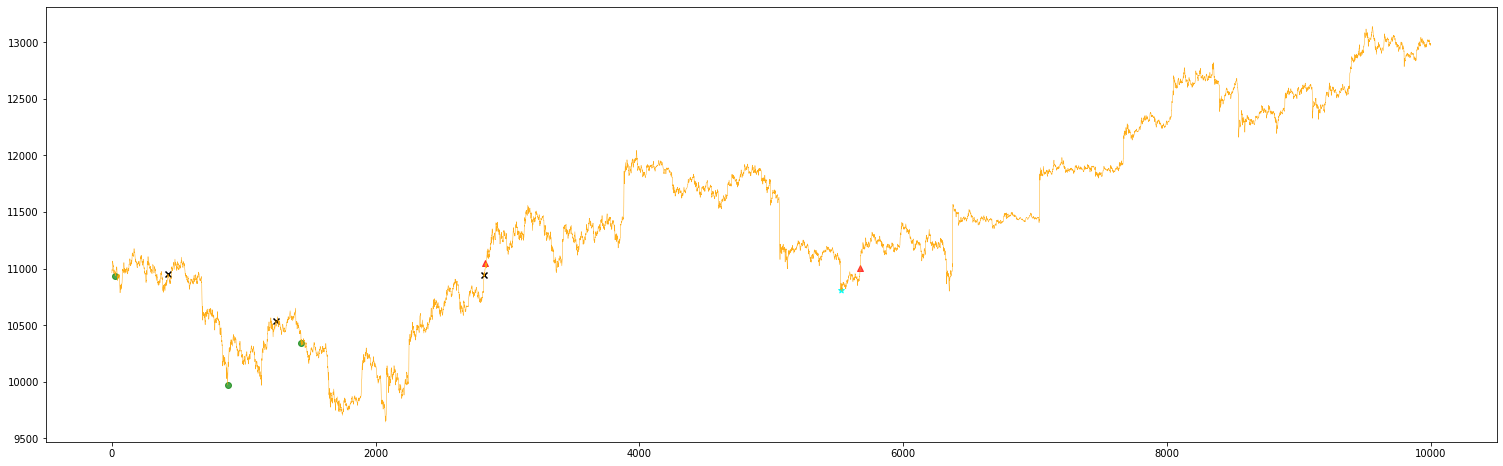

In [64]:
number = 10000
df = scrap_data(df)
df = prep_data(df)
def trace_it3(df):
    trigger = 0
    plt.figure(figsize=(26,8))
    plt.plot(df.iloc[:,-1],c='orange',alpha=0.9,linewidth=0.5)
    pos_long_BTCUSD = 0
    pos_short_BTCUSD = 0
    bloko = df.iloc[0,-1]
    blokx = df.iloc[0,-1]
    side = ''
    for i in range(0,len(df)-1):
        
        #if pos_short_BTCUSD > 1 or pos_long_BTCUSD > 1 or trigger > 1:
        #    print('Error - ',pos_short_BTCUSD,pos_long_BTCUSD, trigger)
        
        
        if df.iloc[i,5] < 1.05 and df.iloc[i,6] < 15 and df.iloc[i,7] > 90 and df.iloc[i,8] < -90 and trigger == 1 and (bloko - df.iloc[i,-1]) > 1 and side =='S':

            plt.scatter(x=i,y=df.iloc[i,-1],c='cyan',marker='*')
            trigger = 0
            side = ''
            blokx = df.iloc[i,-1] 
        
        if df.iloc[i,5] > 99 and df.iloc[i,6] == 100 and df.iloc[i,7] < 5 and df.iloc[i,8] > 99 and trigger == 1 and (df.iloc[i,-1] - bloko) > 1 and side == 'B':
            
            plt.scatter(x=i,y=df.iloc[i,-1],c='black',marker='x')
            trigger = 0
            side = ''
            blokx = df.iloc[i,-1]



        if df.iloc[i,5] < 1.05 and df.iloc[i,6] < 15 and df.iloc[i,7] > 90 and df.iloc[i,8] < -90 and trigger == 0 and (blokx - df.iloc[i,-1]) > 1 and df.iloc[i,9] > df.iloc[i,-1]:

            plt.scatter(x=i,y=df.iloc[i,-1],c='g',marker='o',alpha=0.7)
            trigger = 1
            side = 'B'
            bloko = df.iloc[i,-1]

        if df.iloc[i,5] > 99 and df.iloc[i,6] == 100 and df.iloc[i,7] < 5 and df.iloc[i,8] > 99 and trigger == 0 and (df.iloc[i,-1] - blokx) > 1 and df.iloc[i,9] < df.iloc[i,-1]:

            plt.scatter(x=i,y=df.iloc[i,-1],c='red',marker='^',alpha=0.7)
            trigger = 1
            side = 'S'
            bloko = df.iloc[i,-1]
                    
    return
trace_it3(df)

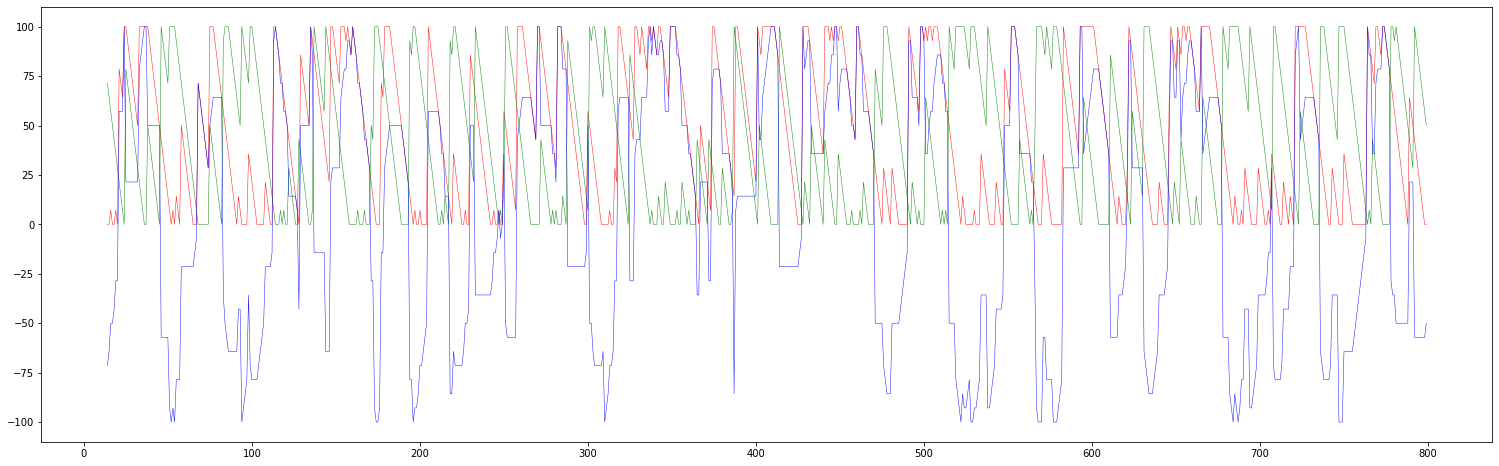

In [23]:
plt.figure(figsize=(26,8))
plt.plot(df.iloc[:,6],c='red',alpha=0.9,linewidth=0.5)
plt.plot(df.iloc[:,7],c='green',alpha=0.9,linewidth=0.5)
plt.plot(df.iloc[:,8],c='blue',alpha=0.9,linewidth=0.5)


In [ ]:
##############################
#### ESSAI ###################
##############################


number = 30
df = scrap_data(df)
df = prep_data(df)
def trace_it3(df):
    trigger = 0
    print('Début',end='')
    pos_long_BTCUSD = 0
    pos_short_BTCUSD = 0
    bloko = df.iloc[0,-1]
    blokx = df.iloc[0,-1]
    side = ''
    for i in range(0,36000):
        print('Loop : ',i,' ',end='',flush=True)
        df = scrap_data(df)
        df = prep_data(df)
        #if pos_short_BTCUSD > 1 or pos_long_BTCUSD > 1 or trigger > 1:
        #    print('Error - ',pos_short_BTCUSD,pos_long_BTCUSD, trigger)
        
        
        if df.iloc[-1,5] < 1.05 and df.iloc[-1,6] < 15 and df.iloc[-1,7] > 90 and df.iloc[-1,8] < -90 and trigger == 1 and (bloko - df.iloc[-1,-1]) > 1 and side =='S':

            #plt.scatter(x=i,y=df.iloc[i,-1],c='cyan',marker='*')
            trigger = 0
            side = ''
            buysell_BTCUSD = 'B'
            blokx = df.iloc[-1,-1]
            request_close_BTCUSD = fx.create_order_request(order_type='CM',
                                                                    ACCOUNT_ID=accountid,
                                                                    OFFER_ID = offerid_BTCUSD,
                                                                    BUY_SELL=buysell_BTCUSD,
                                                                    AMOUNT=amount_BTCUSD,
                                                                    TIME_IN_FORCE='IOC',
                                                                    TRADE_ID =trade_id_BTCUSD)
            resp_close_BTCUSD = fx.send_request(request_close_BTCUSD)

            closed_table = table_manager.get_table(fx.CLOSED_TRADES)
            for row in closed_table:
                if row['trade_id'] == trade_id_BTCUSD:
                    trade =None
                    side_BTCUSD = row['buy_sell']
                    pnl_BTCUSD = row['pl']
                    trade_id_BTCUSD = row['trade_id']
                    open_rate_BTCUSD = row['open_rate']
                    amount_BTCUSD = row['amount']
                    open_time_BTCUSD = row['open_time']
                    close_rate_BTCUSD = row['close_rate']
                    close_time_BTCUSD = row['close_time']

            print('\033[47m \033[31m Close Short avec un pnl de', pnl_BTCUSD,'\033[0m')
            print('Résumé : ')
            print(' Open date : ', open_time_BTCUSD)
            print('Open Rate : ',open_rate_BTCUSD)
            print('Amount : ',amount_BTCUSD)
            print('')
        
        if df.iloc[-1,5] > 99 and df.iloc[-1,6] == 100 and df.iloc[-1,7] < 5 and df.iloc[-1,8] > 99 and trigger == 1 and (df.iloc[-1,-1] - bloko) > 1 and side == 'B':
            
            #plt.scatter(x=i,y=df.iloc[i,-1],c='black',marker='x')
            trigger = 0
            side = ''
            buysell_BTCUSD = 'S'
            blokx = df.iloc[-1,-1]
            request_close_BTCUSD = fx.create_order_request(order_type='CM',
                                                                    ACCOUNT_ID=accountid,
                                                                    OFFER_ID = offerid_BTCUSD,
                                                                    BUY_SELL=buysell_BTCUSD,
                                                                    AMOUNT=amount_BTCUSD,
                                                                    TIME_IN_FORCE='IOC',
                                                                    TRADE_ID =trade_id_BTCUSD)
            resp_close_BTCUSD = fx.send_request(request_close_BTCUSD)

            closed_table = table_manager.get_table(fx.CLOSED_TRADES)
            for row in closed_table:
                if row['trade_id'] == trade_id_BTCUSD:
                    trade =None
                    side_BTCUSD = row['buy_sell']
                    pnl_BTCUSD = row['pl']
                    trade_id_BTCUSD = row['trade_id']
                    open_rate_BTCUSD = row['open_rate']
                    amount_BTCUSD = row['amount']
                    open_time_BTCUSD = row['open_time']
                    close_rate_BTCUSD = row['close_rate']
                    close_time_BTCUSD = row['close_time']

            print('\033[47m \033[31m Close Short avec un pnl de', pnl_BTCUSD,'\033[0m')
            print('Résumé : ')
            print(' Open date : ', open_time_BTCUSD)
            print('Open Rate : ',open_rate_BTCUSD)
            print('Amount : ',amount_BTCUSD)
            print('')



        if df.iloc[-1,5] < 1.05 and df.iloc[-1,6] < 15 and df.iloc[-1,7] > 90 and df.iloc[-1,8] < -90 and trigger == 0 and (blokx - df.iloc[-1,-1]) > 1 and df.iloc[-1,9] > df.iloc[-1,-1]:

            #plt.scatter(x=i,y=df.iloc[i,-1],c='g',marker='o',alpha=0.7)
            trigger = 1
            side = 'B'
            bloko = df.iloc[-1,-1]
            buysell_BTCUSD = 'B'

            request_open_BTCUSD = fx.create_order_request(\
                SYMBOL=ticker,\
                order_type='OM',\
                ACCOUNT_ID=accountid,\
                BUY_SELL=buysell_BTCUSD,\
                AMOUNT=amount_BTCUSD,\
                TIME_IN_FORCE='IOC'\
                )
            resp_open_BTCUSD = fx.send_request(request_open_BTCUSD)
            order_id_BTCUSD = resp_open_BTCUSD.order_id
            offer_BTCUSD = Common.get_offer(fx,ticker)
            offerid_BTCUSD = offer_BTCUSD.offer_id
            table_manager = fx.table_manager
            trades_table = table_manager.get_table(fx.TRADES)
            print('Actualisation des tables')
            time.sleep(0.5)
            for row in trades_table:
                side_BTCUSD = row['buy_sell']
                pnl_BTCUSD = row['pl']
                trade_id_BTCUSD = row['trade_id']
                open_rate_BTCUSD = row['open_rate']
                amount_BTCUSD = row['amount']
                print('Side',side_BTCUSD,'pnl : ',pnl_BTCUSD,'Trade_ID : ',trade_id_BTCUSD,'Open_Rate',open_rate_BTCUSD,'Amount',amount_BTCUSD)

            print('Résumé : ')
            print(' Open date : ', open_time_BTCUSD)
            print('Open Rate : ',open_rate_BTCUSD)
            print('Amount : ',amount_BTCUSD)
            print('pnl : ',pnl_BTCUSD)
            print('Order : ',trade_id_BTCUSD)
            print('')
            print('                                                    Go Long!')
            
            

        if df.iloc[-1,5] > 99 and df.iloc[-1,6] == 100 and df.iloc[-1,7] < 5 and df.iloc[-1,8] > 99 and trigger == 0 and (df.iloc[-1,-1] - blokx) > 1 and df.iloc[-1,9] < df.iloc[-1,-1]:

            #plt.scatter(x=i,y=df.iloc[i,-1],c='red',marker='^',alpha=0.7)
            trigger = 1
            side = 'S'
            bloko = df.iloc[-1,-1]
            buysell_BTCUSD = 'S'

            request_open_BTCUSD = fx.create_order_request(\
                SYMBOL=ticker,\
                order_type='OM',\
                ACCOUNT_ID=accountid,\
                BUY_SELL=buysell_BTCUSD,\
                AMOUNT=amount_BTCUSD,\
                TIME_IN_FORCE='IOC'\
                )
            resp_open_BTCUSD = fx.send_request(request_open_BTCUSD)
            order_id_BTCUSD = resp_open_BTCUSD.order_id
            offer_BTCUSD = Common.get_offer(fx,ticker)
            offerid_BTCUSD = offer_BTCUSD.offer_id
            table_manager = fx.table_manager
            trades_table = table_manager.get_table(fx.TRADES)
            print('Actualisation des tables')
            time.sleep(0.5)
            for row in trades_table:
                side_BTCUSD = row['buy_sell']
                pnl_BTCUSD = row['pl']
                trade_id_BTCUSD = row['trade_id']
                open_rate_BTCUSD = row['open_rate']
                amount_BTCUSD = row['amount']
                print('Side',side_BTCUSD,'pnl : ',pnl_BTCUSD,'Trade_ID : ',trade_id_BTCUSD,'Open_Rate',open_rate_BTCUSD,'Amount',amount_BTCUSD)

            print('Résumé : ')
            print(' Open date : ', open_time_BTCUSD)
            print('Open Rate : ',open_rate_BTCUSD)
            print('Amount : ',amount_BTCUSD)
            print('pnl : ',pnl_BTCUSD)
            print('Order : ',trade_id_BTCUSD)
            print('')
            print('                                                    Go Long!')
                    
    return
trace_it3(df)

DébutLoop :  0  Loop :  1  Loop :  2  Loop :  3  Loop :  4  Loop :  5  Loop :  6  Loop :  7  Loop :  8  Loop :  9  Loop :  10  Loop :  11  Loop :  12  Loop :  13  Loop :  14  Loop :  15  Loop :  16  Loop :  17  Loop :  18  Loop :  19  Loop :  20  Loop :  21  Loop :  22  Loop :  23  Loop :  24  Loop :  25  Loop :  26  Loop :  27  Loop :  28  Loop :  29  Loop :  30  Loop :  31  Loop :  32  Loop :  33  Loop :  34  Loop :  35  Loop :  36  Loop :  37  Loop :  38  Loop :  39  Loop :  40  Loop :  41  Loop :  42  Loop :  43  Loop :  44  Loop :  45  Loop :  46  Loop :  47  Loop :  48  Loop :  49  Loop :  50  Loop :  51  Loop :  52  Loop :  53  Loop :  54  Loop :  55  Loop :  56  Loop :  57  Loop :  58  Loop :  59  Loop :  60  Loop :  61  Loop :  62  Loop :  63  Loop :  64  Loop :  65  Loop :  66  Loop :  67  Loop :  68  Loop :  69  Loop :  70  Loop :  71  Loop :  72  Loop :  73  Loop :  74  Loop :  75  Loop :  76  Loop :  77  Loop :  78  Loop :  79  Loop :  80  Loop :  81  Loop :  82  Loop :  8

In [70]:
df.tail()

,Date,Open,High,Low,Close,RSI,Aroon Up,Aroon Down,Delta Aroon,EMA20,SAR,ATR,Bid_Close
25,2019-07-10 11:21:00,12997.0,12999.0,12980.0,12988.0,5.758457,21.428571,100.000000,-78.571429,12998.824931,13030.670000,14.900613,12988.0
26,2019-07-10 11:22:00,12988.0,13002.0,12980.0,13000.0,65.640437,14.285714,100.000000,-85.714286,12998.936843,13028.643200,15.407713,13000.0
27,2019-07-10 11:23:00,13000.0,13000.0,12977.5,12995.0,42.916047,7.142857,100.000000,-92.857143,12998.561905,13026.697472,15.914304,12995.0
28,2019-07-10 11:24:00,12995.0,13006.0,12990.5,12997.5,57.596073,0.000000,92.857143,-92.857143,12998.460771,13023.745624,15.884711,12997.5
29,2019-07-10 11:25:00,12997.5,13002.0,12997.0,12998.0,61.551160,0.000000,85.714286,-85.714286,12998.416888,13020.970886,15.107232,12998.0
